In [1]:
! pip3 install soundfile 
! pip3 install librosa
! pip3 install matplotlib 


In [1]:
import tensorflow as tf
from functions import *

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



Num GPUs Available:  1


In [9]:
import gc
gc.collect()


1588

In [12]:
from tensorflow.keras.backend import clear_session
clear_session()


In [4]:
import hyperparameters as hp
directory_path = 'LA/ASVspoof2019_LA_train/flac'

In [5]:
import os
import tensorflow as tf

# add a if statement that if train_dataset.pkl exists, load it, else create it

if os.path.exists('dataset_pickle_dumps/train_dataset_dumped.pkl'):
    print("LOADING TRAIN DATASET FROM FILE")
    dataset = tf.data.experimental.load('dataset_pickle_dumps/train_dataset_dumped.pkl')
    print("TRAIN DATASET LOADED FROM FILE")
    
else:

    with open('train_preprocessed.txt', 'r') as file:
        data = file.readlines()

    file_names = []
    labels = []

    subset_size = 1000
    for line in data:
        if subset_size == 0:
            break
        # subset_size -= 1
        file_name, label = line.split()
        file_names.append(file_name)
        labels.append(int(label))

    tensors = []

    ctr = 0 


    for file_name in file_names:
        ctr+=1
        if ctr % 200 == 0:
            print(f"PROGRESS: {ctr}/{len(file_names)}")
        file_path = os.path.join(directory_path, file_name)
        signal, sample_rate = read_flac_file(file_path)
        lfcc_features = extract_lfcc(signal, sample_rate)
        tensor = tf.convert_to_tensor(lfcc_features)
        tensor = tf.expand_dims(tensor, axis=0)
        tensors.append(tensor[0])
        
    labels = tf.convert_to_tensor(labels)

    dataset = tf.data.Dataset.from_tensor_slices((tensors, labels))

    dataset = dataset.shuffle(buffer_size=len(tensors)).batch(32)

    tf.data.experimental.save(dataset, 'dataset_pickle_dumps/train_dataset_dumped.pkl')

    print("TRAIN DATASET DUMPED TO FILE")

print("NUMBER OF ENTRIES IN TRAINING DATASET: ", len(dataset))


LOADING TRAIN DATASET FROM FILE
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
TRAIN DATASET LOADED FROM FILE
NUMBER OF ENTRIES IN TRAINING DATASET:  794


In [6]:
for tensor, label in dataset.take(1):
    print(tensor.shape)
    print(label.shape)

(32, 1, 10, 300)
(32,)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Conv2D(filters // ratio, 1, activation='relu')(se)
    se = layers.Conv2D(filters, 1, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, se])

def mb_conv1_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, input_tensor])

def mb_conv6_block(input_tensor, kernel_size=3, filters=16, dropout_rate=0.2):
    input_filters = input_tensor.shape[-1]
    if input_filters != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Conv2D(filters * 6, (1, 1), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.DepthwiseConv2D((kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    return layers.Add()([x, shortcut])

def BasicBlock(input_tensor, c_in, c_out):
    x = layers.Conv2D(c_out, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(c_out, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def attention_branch(input_tensor):
    x = BasicBlock(input_tensor, 1, 2)
    x = BasicBlock(x, 2, 4)
    x = BasicBlock(x, 4, 8)
    x = BasicBlock(x, 8, 16)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (1, 1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(1, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    A = layers.Activation('sigmoid')(x)
    return A

def EfficientNet_A0_with_attention(input_shape=(1, hp.F, hp.T), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    A = attention_branch(inputs)
    print("A shape: ", A.shape)
    A_adjusted = layers.GlobalAveragePooling2D()(A)
    A_adjusted = layers.Reshape((1,))(A_adjusted)
    print("A_adjusted shape: ", A_adjusted.shape)
    x = layers.Conv2D(32, (1, 1), padding='same')(inputs)
    x = mb_conv1_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=32, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=48, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = mb_conv6_block(x, filters=64, dropout_rate=dropout_rate)
    x = layers.Conv2D(1280, (1, 1), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)
    R = layers.GlobalAveragePooling2D()(x)
    R_output = layers.Dense(1, activation='sigmoid')(R)
    combined_output = R_output + R_output * A_adjusted
    model = models.Model(inputs, combined_output)
    return model

# Adding regularization 

from keras import regularizers, losses

def custom_loss(y_true, y_pred):
    bce = losses.binary_crossentropy(y_true, y_pred)
    reg = regularizers.l2(0.06)
    regularization = tf.reduce_sum(reg(y_pred)) * tf.reduce_max(y_pred)
    loss = bce + regularization
    return loss


# shape: (1xFxT)
input_shape = (1, hp.F, hp.T)
model = EfficientNet_A0_with_attention(input_shape=input_shape)
model.compile(optimizer='adam', loss= custom_loss, metrics=['accuracy'])
model.summary()


A shape:  (None, 1, 10, 1)
A_adjusted shape:  (None, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 10, 300)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_10 (Conv2D)             (None, 1, 10, 32)    9632        ['input_1[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 1, 10, 32)    9248        ['conv2d_10[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None

In [ ]:
class BasicBlock (tf.keras.Layer):
    def __init__(self,C_in,C_out):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(C_out, (3, 3), padding='same', data_format='channels_first')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(C_out, (3, 3), padding='same', data_format='channels_first')
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self, input):
        input = self.conv1(input)
        input = self.bn1(input)
        input = self.conv2(input)
        input = self.bn2(input)
        return input
    
class SEBlock (tf.keras.Model):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.gap = tf.keras.layers.GlobalAveragePooling2D()

class AttentionBranch (tf.keras.Model):
    def __init__(self,):
        super(AttentionBranch, self).__init__()
        self.bb1 = BasicBlock(1,2)
        self.bb2 = BasicBlock(2,4)
        self.bb3 = BasicBlock(4,8)
        self.bb4 = BasicBlock(8,16)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(16, (1, 1), padding='same', data_format='channels_first')
        self.relu = tf.keras.layers.ReLU()
        self.ab_output_conv = tf.keras.layers.Conv2D(2, (1, 1), padding='same', data_format='channels_first')
        self.ab_output_gap = tf.keras.layers.GlobalAveragePooling2D()
        self.ab_output_softmax = tf.keras.layers.Softmax()
        self.attention_map_conv = tf.keras.layers.Conv2D(1, (1, 1), padding='same', data_format='channels_first')
        self.attention_map_bn = tf.keras.layers.BatchNormalization()
        self.attention_map_sigmoid = tf.keras.layers.Activation('sigmoid')
    
    def call (self, input):
        output = self.bb1(input)
        output = self.bb2(output)
        output = self.bb3(output)
        output = self.bb4(output)
        output = self.bn1(output)
        output = self.conv1(output)
        output = self.relu(output)
        ab_output =  self.ab_output_conv(output)
        ab_output = self.ab_output_gap(ab_output)
        ab_output = self.ab_output_softmax(ab_output)
        attention_map = self.attention_map_conv(output)
        attention_map = self.attention_map_bn(attention_map)
        attention_map = self.attention_map_sigmoid(attention_map)
        return ab_output, attention_map
        
        

In [11]:
'''
labels

one_ctr = 0 
zero_ctr = 0 

for i in labels : 
    if i == 0: 
        zero_ctr +=1
    else : 
        one_ctr +=1

print(one_ctr , zero_ctr)
'''

'\nlabels\n\none_ctr = 0 \nzero_ctr = 0 \n\nfor i in labels : \n    if i == 0: \n        zero_ctr +=1\n    else : \n        one_ctr +=1\n\nprint(one_ctr , zero_ctr)\n'

In [8]:
from keras.callbacks import Callback
from scipy.special import softmax
import numpy as np
from sklearn.metrics import roc_curve

class ClassWiseAccuracy(Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, n_epochs_training, logs=None):
        y_true = []
        y_pred = []
        for x, y in self.dataset:
            y_true.extend(y.numpy())
            predictions = self.model.predict(x, verbose=0)
            if predictions.shape[1] == 1:
                predictions = np.hstack([1 - predictions, predictions])
            predictions = softmax(predictions, axis=-1)
            y_pred.extend((predictions[:, 1] > 0.5).astype(int))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        class_0_indices = np.where(y_true == 0)
        class_1_indices = np.where(y_true == 1)

        class_0_accuracy = np.mean(y_true[class_0_indices] == y_pred[class_0_indices])
        class_1_accuracy = np.mean(y_true[class_1_indices] == y_pred[class_1_indices])

        print(f"Epoch {n_epochs_training + 1}:")
        print(f"Accuracy for class 0 (bonafide): {class_0_accuracy}")
        print(f"Accuracy for class 1 (spoofed): {class_1_accuracy}")

        # print EER 
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
        print(f"EER: {eer}")

              


model.fit(dataset, epochs= hp.n_epochs_training, callbacks=[ClassWiseAccuracy(dataset)])
model.save('model.keras')

794/794 [==============================] - ETA: 0s - loss: 0.9760 - accuracy: 0.5541

KeyboardInterrupt: 

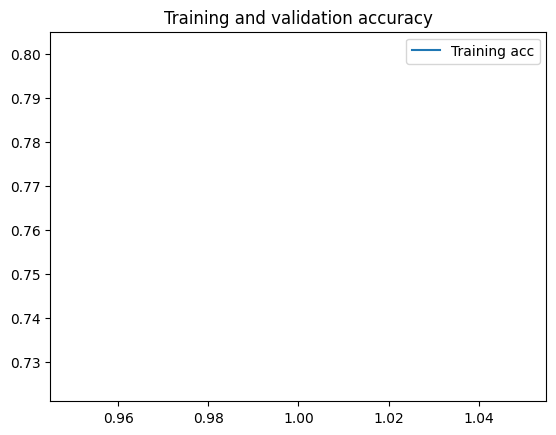

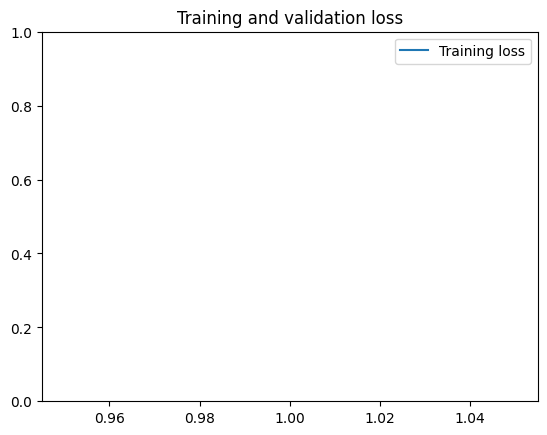

In [ ]:
def plot_history(history):
    import matplotlib.pyplot as plt
    
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training acc')
    # plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    # plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

plot_history(model.history)

In [ ]:
# load model from pkl

# model = tf.keras.models.load_model('model.keras')


# model.evaluate(dataset_val)
# predictions = model.predict(dataset_val)

In [ ]:
print("TRAINING OF THE MODEL IS DONE!")

TRAINING OF THE MODEL IS DONE!


In [ ]:
#os._exit(00)